In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
dct = {}
for folder in os.listdir('insects'):
    dct[folder] = len(os.listdir(os.path.join('insects',folder)))

In [4]:
pd.Series(dct).sort_values(ascending=False).head(2)

Pissodes strobi (Peck)      168
Helicoverpa zea (Boddie)    154
dtype: int64

In [5]:
pd.Series(dct).sort_values(ascending=False).head(2).sum()

322

In [6]:
label_set = os.listdir('insects')
len(label_set)

2273

In [7]:
def encode_y(y, dct = {label : enc for label, enc in zip(label_set, range(len(label_set)))}):
    print(f'{y} : {dct[y]}')
    return str(dct[y])

In [8]:
import shutil

try:
    directory_path = "selected_insects"
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)
        if os.path.isfile(item_path):
            os.remove(item_path)  # Delete files using os.remove()
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Delete subdirectories recursively using shutil.rmtree()
except: pass


source_dir = "insects"
destination_dir = "selected_insects"

# Create the new folder (if it doesn't exist)
os.makedirs(destination_dir, exist_ok=True)  # Handles existing folders


subdirectories = pd.Series(dct).sort_values(ascending=False).head(2).index

# Copy each subdirectory to the new folder
for subdirectory in subdirectories:
    source_subdir = os.path.join(source_dir, subdirectory)
    dest_subdir = os.path.join(destination_dir, encode_y(subdirectory))
    shutil.copytree(source_subdir, dest_subdir)

print(f"Successfully copied subdirectories from {source_dir} to {destination_dir}")

Pissodes strobi (Peck) : 1738
Helicoverpa zea (Boddie) : 1070
Successfully copied subdirectories from insects to selected_insects


In [9]:
class ImageFolderWithLabels(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_paths = [os.path.join(root, filename) for root, _, filenames in os.walk(data_dir) for filename in filenames if filename.lower().endswith((".jpg", ".jpeg", ".png"))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = int(os.path.basename(os.path.dirname(image_path)))  # Extract label from directory name
        image = Image.open(image_path).convert('RGB')  # Assuming RGB images
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
image_size = 224

transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize all images to the specified size
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize pixel values
    # Optionally add random cropping for data augmentation
    transforms.RandomCrop(image_size)
])

dataset = ImageFolderWithLabels('selected_insects', transform=transform)

In [11]:
test_size = 0.2
train_size = 1 - test_size
batch_size = 2
train_dataset, test_dataset = random_split(dataset, lengths=[int(len(dataset) * train_size), len(dataset) - int(len(dataset) * train_size)])

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Define Our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
conv1 = nn.Conv2d(3, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [14]:
for i, (X_Train, y_train) in enumerate(train_dataset):
  break
X_Train.shape

torch.Size([3, 224, 224])

In [15]:
x = X_Train.view(1, 3, 224, 224)

In [16]:
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 222, 222])

In [17]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 6, 111, 111])

In [18]:
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 109, 109])

In [19]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 54, 54])

In [20]:
ns = 16* 54* 54

In [21]:
label_set = os.listdir('selected_insects')
len(label_set)

2

In [22]:
len(dataset)

322

In [23]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 3, 1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(ns, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, len(label_set))

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1, ns) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [24]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model.to(device)
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # Smaller the Learning Rate, longer its gonna take to train.

In [26]:
def encode_y(y, dct = {label : enc for label, enc in zip(label_set, range(len(label_set)))}):
    encs = []
    for label in y:
        encs.append(dct[str(label)])
    return  torch.tensor(encs, dtype=torch.long)

In [27]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_dataloader):
    b+=1 # start our batches at 1
    y_train = encode_y((y_train.cpu().numpy()))  # Convert to long tensor for labels
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%15 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_dataloader):
      y_test = encode_y((y_test.cpu().numpy()))  # Convert to long tensor for labels
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 15  Loss: 3.5762659535976127e-06
Epoch: 0  Batch: 30  Loss: 1.6686921119689941
Epoch: 0  Batch: 45  Loss: 5.015833377838135
Epoch: 0  Batch: 60  Loss: 0.7644631862640381
Epoch: 0  Batch: 75  Loss: 0.6962040662765503
Epoch: 0  Batch: 90  Loss: 0.9506651759147644
Epoch: 0  Batch: 105  Loss: 0.6931768655776978
Epoch: 0  Batch: 120  Loss: 0.7072827219963074
Epoch: 1  Batch: 15  Loss: 0.5774755477905273
Epoch: 1  Batch: 30  Loss: 0.6319498419761658
Epoch: 1  Batch: 45  Loss: 0.7077175974845886
Epoch: 1  Batch: 60  Loss: 1.1113327741622925
Epoch: 1  Batch: 75  Loss: 0.6903539299964905
Epoch: 1  Batch: 90  Loss: 0.7798898220062256
Epoch: 1  Batch: 105  Loss: 0.7660588622093201
Epoch: 1  Batch: 120  Loss: 0.6574403047561646
Epoch: 2  Batch: 15  Loss: 0.8965315222740173
Epoch: 2  Batch: 30  Loss: 0.886214017868042
Epoch: 2  Batch: 45  Loss: 0.46936142444610596
Epoch: 2  Batch: 60  Loss: 1.276047706604004
Epoch: 2  Batch: 75  Loss: 0.6448423862457275
Epoch: 2  Batch: 90  Loss: 0

In [28]:
y_train.cpu().numpy()

array([1], dtype=int64)

In [29]:
y_train

tensor([1])

In [30]:
torch.max(y_pred.data, 1)[1]

tensor([1])

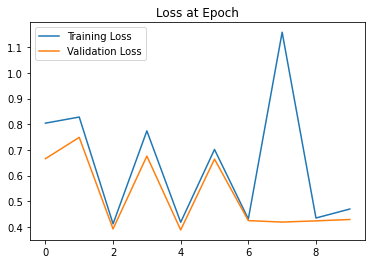

In [31]:
# Graph the loss at epoch
train_losses = [tl.cpu().detach().numpy() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot([t.cpu() for t in test_losses], label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend();

In [32]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_dataloader:
    X_test = X_test.to(device)
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted.cpu() == encode_y((y_test.cpu().numpy()))).sum()

In [33]:
correct.item()/len(test_dataloader)*100

96.96969696969697

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


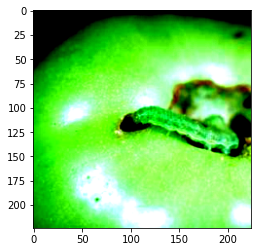

In [34]:
plt.imshow(np.transpose(dataset[1][0], (1, 2, 0)))
plt.show()

In [35]:
dataset[1][1]

1070

In [42]:
dataset[1][0].to(device).shape

torch.Size([3, 224, 224])

In [36]:
model.eval()
with torch.no_grad():
  new_prediction = model(dataset[1][0].to(device))

In [37]:
int(new_prediction.argmax().cpu().numpy())

1

In [38]:
def decode_y(y, dct = {enc : label for label, enc in zip(label_set, range(len(label_set)))}):
    decs = []
    for enc in y:
        decs.append(dct[enc])
    return  decs

decode_y([int(new_prediction.argmax().cpu().numpy())])

['1738']

In [40]:
torch.save(model, "model.pt")
torch.save(model.state_dict(), "model_state_dict.pt")

In [ ]:
model()